# EDA notebook for eye tracking dataset
### Obtained from source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6IZ0TK
Written by Casey Munk on 6/11/2024

### Imports

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
import os

### Helper functions

In [14]:
def codify_feature(df: pd.DataFrame, column: str, map: dict) -> pd.DataFrame:
    """
    Codifies a feature in the DataFrame by mapping its values.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the original feature.
    column (str): The name of the column in the DataFrame to be codified.
    map (dict): A dictionary defining the mapping from original values to codified values.

    Returns:
    pd.DataFrame: The DataFrame with the now codified feature.
    """
    
    df[column] = df[column].map(map)
    return df

### Connect to database and read in data

In [9]:
PROJ_DIRECTORY = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIRECTORY = os.path.join(PROJ_DIRECTORY, 'database')
OUTPUT_DIRECTORY = os.path.join(PROJ_DIRECTORY, 'outputs')
MODEL_DIRECTORY = os.path.join(PROJ_DIRECTORY, 'models')

marginal =  pd.read_csv(os.path.join(DATA_DIRECTORY, 'Data_eyeMovements_marginal.csv'))
complete_trial =  pd.read_csv(os.path.join(DATA_DIRECTORY, 'Data_gazeDeviation_completeTrial.csv'))
perform =  pd.read_csv(os.path.join(DATA_DIRECTORY, 'Data_performance.csv'))
self_reported =  pd.read_csv(os.path.join(DATA_DIRECTORY, 'Data_selfReported.csv'))
marginal

subjectID sessionType  session sessionTime  trial  sleepScore  \
0           1          MA        1           M      1           1   
1           1          MA        1           M      2           1   
2           1          MA        2           A      1           1   
3           1          MA        2           A      2           1   
4           2          MA        1           M      1           2   
..        ...         ...      ...         ...    ...         ...   
81         26          AM        2           M      2           1   
82         27          MA        1           M      1           1   
83         27          MA        1           M      2           1   
84         27          MA        2           A      1           1   
85         27          MA        2           A      2           1   

    caffeineScore  alertnessScore  gazeDeviation  angular_velocity_gain  
0               4               5       1.654252               0.809592  
1               4               5       3.136516               0.775999  
2               3               4       2.463788               0.988573  
3               3               4       3.090098               0.931487  
4               4               6       2.898291               0.854306  
..            ...             ...            ...                    ...  
81              4               5       2.265498               0.872967  
82              0               1       2.593296               0.983046  
83              0               1       3.036665               1.050465  
84              3               4       2.215605               1.043273  
85              3               4       2.374723               1.080850  

[86 rows x 10 columns]

# Preprocessing

### Merge all relevant features

In [10]:
merged_df = pd.merge(marginal, self_reported, on=['subjectID', 'session', 'sessionType', 'sessionTime', 'sleepScore', 'caffeineScore', 'alertnessScore'])

# merge complete trial data
merged_df = pd.merge(merged_df, complete_trial, on=['subjectID', 'session', 'sessionType', 'sessionTime', 'trial'], suffixes=('_marginal', '_complete'))

# merge performance data
merged_df = pd.merge(merged_df, perform, on=['subjectID', 'session', 'sessionType', 'sessionTime', 'trial'], suffixes=('', '_performance'))

#remove the extra people who didn't show up for their second trial
merged_df = merged_df[~merged_df['subjectID'].isin([15, 18, 19])]

Recall that mentalFatigue is collected before and after each session (see below), so we need to split the dataset and isolate the "after" mental fatigue scores to act as our outcome variable. The "before" mental fatigue scores will still be included in the final DataFrame as an optional input during model exploration.

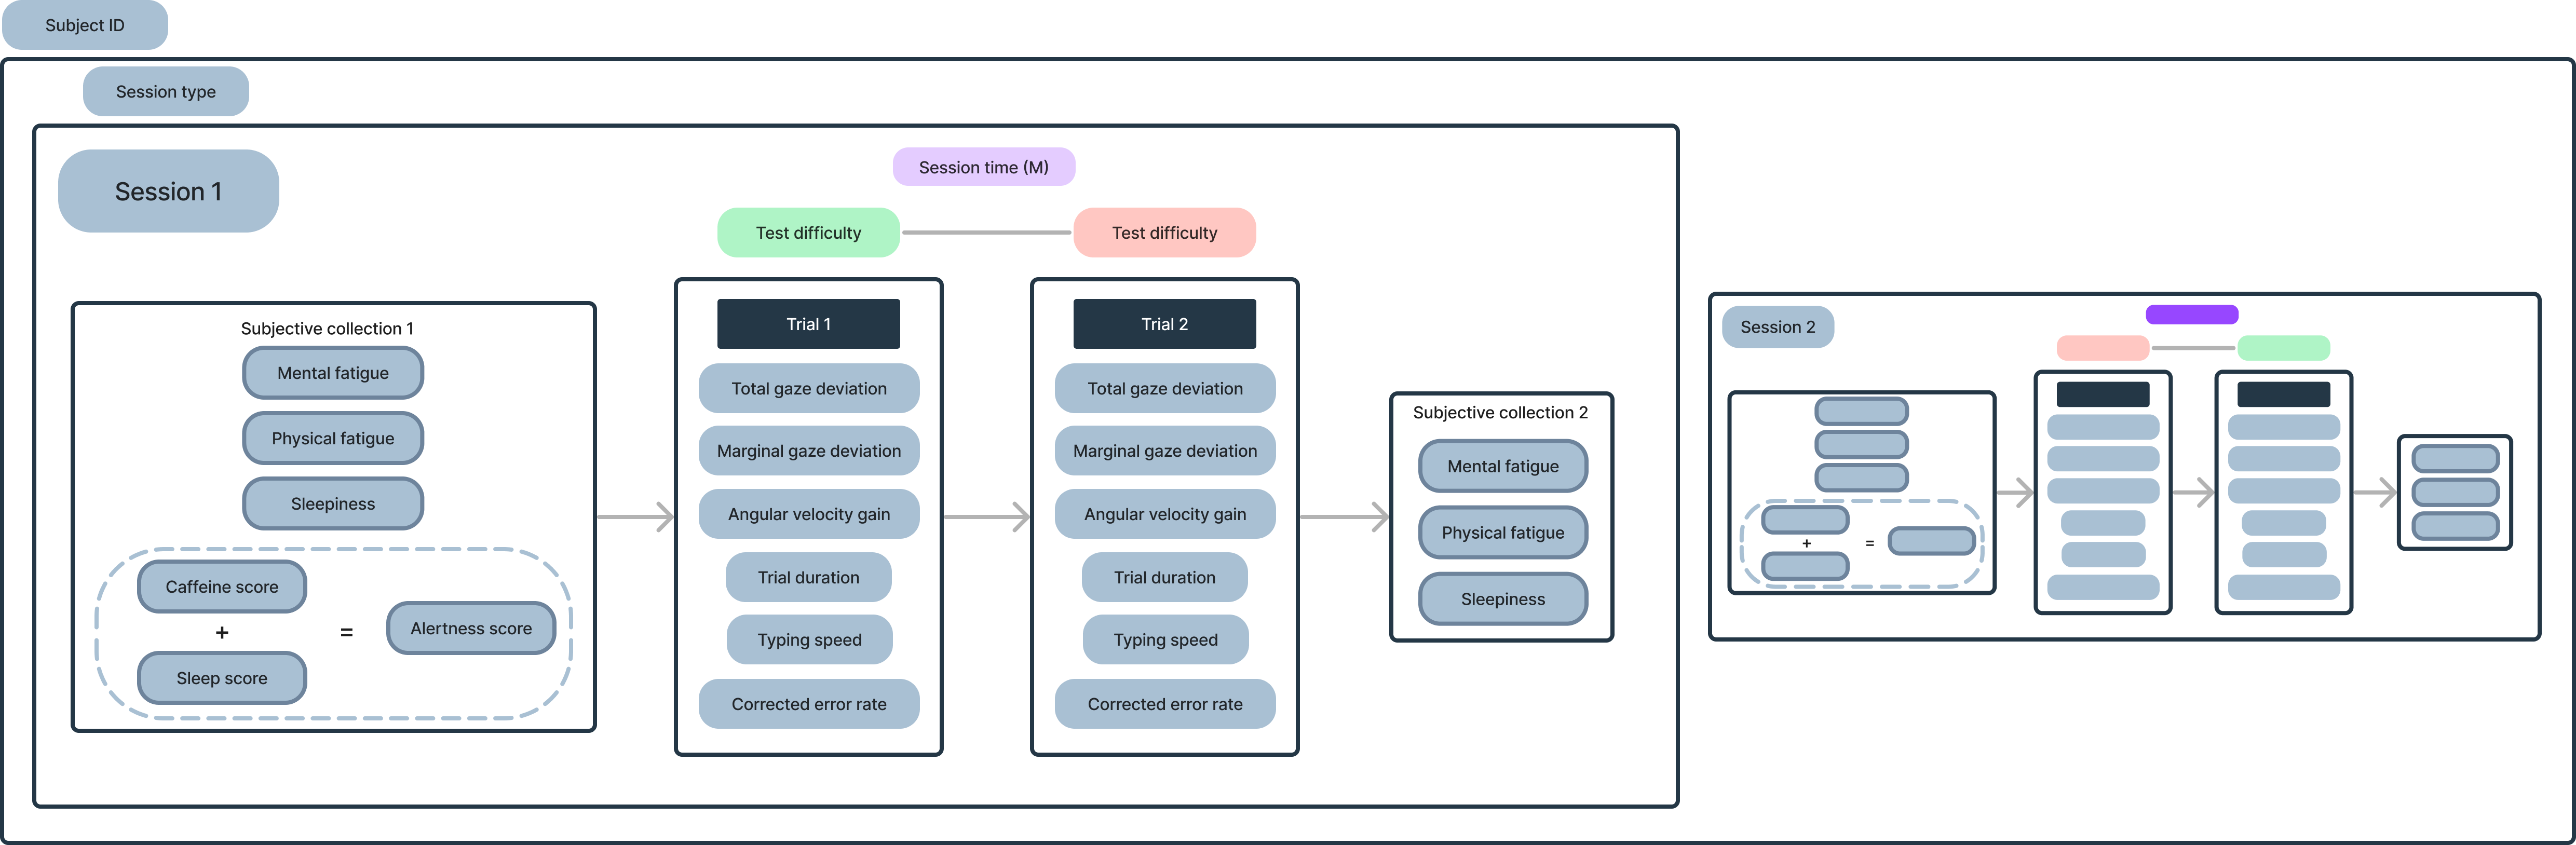

In [11]:
### splitting the merged dataset so we can isolate mental fatigue after the trials are complete
before = merged_df[merged_df['timeOfReport'].str.contains('before')]
before = before.reset_index()
after = merged_df[merged_df['timeOfReport'].str.contains('after')]
after=after.reset_index()

Now that we have the data split by "before" and "after", recall that we still want those subjective measures to be considered as optional inputs to our model, so we will make a final df that contains the "subjective collection 1" metrics and ONLY the Mental fatigue feature from "subjective collection 2" as the intended output. However, we have also retained "physicalFatigue" and "sleepiness" as optional outcome variables in the future; for now, they are not intended for use.

In [12]:
final_df = before.rename(columns={"mentalFatigue":'mentalFatigue_before', 
                                  "physicalFatigue":'physicalFatigue_before',
                                  "sleepiness":'sleepiness_before'})

#add the mental fatigue outcome column
temp = after[["mentalFatigue", "physicalFatigue", "sleepiness"]]
temp = temp.reset_index()
final_df = pd.concat([final_df, temp], axis=1)

# remove duplicate measures from initial merges
final_df = final_df.drop(columns=['index','sleepScore_complete', "caffeineScore_complete", "alertnessScore_complete", 'sleepScore_marginal', "caffeineScore_marginal", "alertnessScore_marginal", 'timeOfReport'])
final_df

subjectID sessionType  session sessionTime  trial  gazeDeviation_marginal  \
0           1          MA        1           M      1                1.654252   
1           1          MA        1           M      2                3.136516   
2           1          MA        2           A      1                2.463788   
3           1          MA        2           A      2                3.090098   
4           2          MA        1           M      1                2.898291   
..        ...         ...      ...         ...    ...                     ...   
75         26          AM        2           M      2                2.265498   
76         27          MA        1           M      1                2.593296   
77         27          MA        1           M      2                3.036665   
78         27          MA        2           A      1                2.215605   
79         27          MA        2           A      2                2.374723   

    angular_velocity_gain  mentalFatigue_before  physicalFatigue_before  \
0                0.809592                     3                       3   
1                0.775999                     3                       3   
2                0.988573                     1                       2   
3                0.931487                     1                       2   
4                0.854306                     2                       2   
..                    ...                   ...                     ...   
75               0.872967                     1                       1   
76               0.983046                     1                       2   
77               1.050465                     1                       2   
78               1.043273                     3                       3   
79               1.080850                     3                       3   

    sleepiness_before  ... sleepScore  caffeineScore  alertnessScore  \
0                   2  ...          1              4               5   
1                   2  ...          1              4               5   
2                   2  ...          1              3               4   
3                   2  ...          1              3               4   
4                   2  ...          2              4               6   
..                ...  ...        ...            ...             ...   
75                  1  ...          1              4               5   
76                  1  ...          1              0               1   
77                  1  ...          1              0               1   
78                  2  ...          1              3               4   
79                  2  ...          1              3               4   

    trialDuration  typingSpeed  correctedErrorRate  falseSelections  \
0      399.293313     1.111965            8.823529        19.178082   
1      448.210546     1.606388           18.627451        24.752475   
2      311.774936     1.655040           11.111111        11.111111   
3      181.115151     1.523892           16.666667        23.529412   
4      373.052926     0.868509           15.000000        21.153846   
..            ...          ...                 ...              ...   
75     358.017037     1.106093           11.475410        15.517241   
76     462.873015     1.140702           23.188406        23.456790   
77     389.072175     0.956121           20.289855        21.538462   
78     357.023045     1.008338           15.068493        17.543860   
79     364.419201     1.547668            8.219178        17.647059   

    mentalFatigue  physicalFatigue  sleepiness  
0               2                3           2  
1               2                3           2  
2               2                2           2  
3               2                2           2  
4               2                1           2  
..            ...              ...         ...  
75              1                1           1  
76              2   

## Encoding
We have a few categorical and binary variables. We will encode these as 0's and 1's following the definitions below. This will be saved in *encoded_df*

__sessionType__
- 0 = MA
- 1 = AM

__sessionTime__
- 0 = M
- 1 = A

__session__
- 0 = 1
- 1 = 2

__trial__
- 0 = 1
- 1 = 2

__trialDifficultyLevel__
- 0 = E
- 1 = D

In [15]:
encoded_df = final_df.copy()

# define rules above
session_type_map = {'MA' : 0, 'AM' : 1}
session_time_map = {'M' : 0, 'A' : 1}
trial_difficulty_map = {'E' : 0, 'D' : 1}

# apply encoding rules using helper function
encoded_df = codify_feature(encoded_df, 'sessionType', session_type_map)
encoded_df = codify_feature(encoded_df, 'sessionTime', session_time_map)
encoded_df = codify_feature(encoded_df, 'trialDifficultyLevel', trial_difficulty_map)

# for trial and session just subtract 1
encoded_df['trial'] = encoded_df['trial'] - 1
encoded_df['session'] = encoded_df['session'] - 1
encoded_df

subjectID  sessionType  session  sessionTime  trial  \
0           1            0        0            0      0   
1           1            0        0            0      1   
2           1            0        1            1      0   
3           1            0        1            1      1   
4           2            0        0            0      0   
..        ...          ...      ...          ...    ...   
75         26            1        1            0      1   
76         27            0        0            0      0   
77         27            0        0            0      1   
78         27            0        1            1      0   
79         27            0        1            1      1   

    gazeDeviation_marginal  angular_velocity_gain  mentalFatigue_before  \
0                 1.654252               0.809592                     3   
1                 3.136516               0.775999                     3   
2                 2.463788               0.988573                     1   
3                 3.090098               0.931487                     1   
4                 2.898291               0.854306                     2   
..                     ...                    ...                   ...   
75                2.265498               0.872967                     1   
76                2.593296               0.983046                     1   
77                3.036665               1.050465                     1   
78                2.215605               1.043273                     3   
79                2.374723               1.080850                     3   

    physicalFatigue_before  sleepiness_before  ...  sleepScore  caffeineScore  \
0                        3                  2  ...           1              4   
1                        3                  2  ...           1              4   
2                        2                  2  ...           1              3   
3                        2                  2  ...           1              3   
4                        2                  2  ...           2              4   
..                     ...                ...  ...         ...            ...   
75                       1                  1  ...           1              4   
76                       2                  1  ...           1              0   
77                       2                  1  ...           1              0   
78                       3                  2  ...           1              3   
79                       3                  2  ...           1              3   

    alertnessScore  trialDuration  typingSpeed  correctedErrorRate  \
0                5     399.293313     1.111965            8.823529   
1                5     448.210546     1.606388           18.627451   
2                4     311.774936     1.655040           11.111111   
3                4     181.115151     1.523892           16.666667   
4                6     373.052926     0.868509           15.000000   
..             ...            ...          ...                 ...   
75               5     358.017037     1.106093           11.475410   
76               1     462.873015     1.140702           23.188406   
77               1     389.072175     0.956121           20.289855   
78               4     357.023045     1.008338           15.068493   
79               4     364.419201     1.547668            8.219178   

    falseSelections  mentalFatigue  physicalFatigue  sleepiness  
0         19.178082              2                3           2  
1         24.752475              2                3           2  
2         11.111111              2                2           2  
3         23.529412              2                2           2  
4         21.153846              2                1           2  
..              ...            ...              ...         ...  
75        15.517241              1                1           1  
76        23.456790              2                1 

---

# Begin EDA

In [16]:
final_df.dtypes

subjectID                   int64
sessionType                object
session                     int64
sessionTime                object
trial                       int64
gazeDeviation_marginal    float64
angular_velocity_gain     float64
mentalFatigue_before        int64
physicalFatigue_before      int64
sleepiness_before           int64
trialDifficultyLevel       object
gazeDeviation_complete    float64
sleepScore                  int64
caffeineScore               int64
alertnessScore              int64
trialDuration             float64
typingSpeed               float64
correctedErrorRate        float64
falseSelections           float64
mentalFatigue               int64
physicalFatigue             int64
sleepiness                  int64
dtype: object

In [17]:
encoded_df.dtypes

subjectID                   int64
sessionType                 int64
session                     int64
sessionTime                 int64
trial                       int64
gazeDeviation_marginal    float64
angular_velocity_gain     float64
mentalFatigue_before        int64
physicalFatigue_before      int64
sleepiness_before           int64
trialDifficultyLevel        int64
gazeDeviation_complete    float64
sleepScore                  int64
caffeineScore               int64
alertnessScore              int64
trialDuration             float64
typingSpeed               float64
correctedErrorRate        float64
falseSelections           float64
mentalFatigue               int64
physicalFatigue             int64
sleepiness                  int64
dtype: object

### boxplots of every numerical feature except trial duration

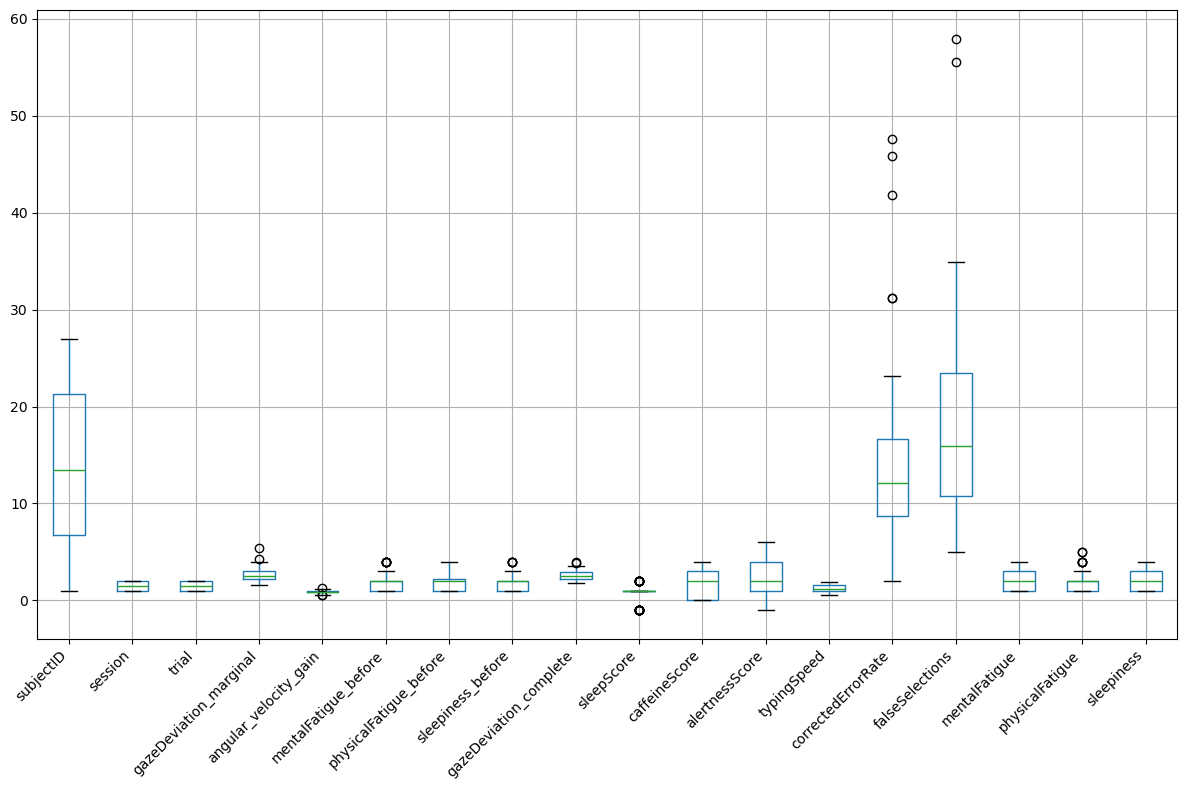

In [17]:
numeric_cols= final_df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop(['trialDuration'])
plt.figure(figsize=(12,8))
final_df[numeric_cols].boxplot()
plt.xticks(rotation=45, ha='right')
# plt.grid(False)
plt.tight_layout()
plt.show()

We have a wide range, so let's cut out those features and look at only the features on a scale of 1-6

### boxplots of numerical features on similar scales
objective: to see how the spread/outliers of each feature differs

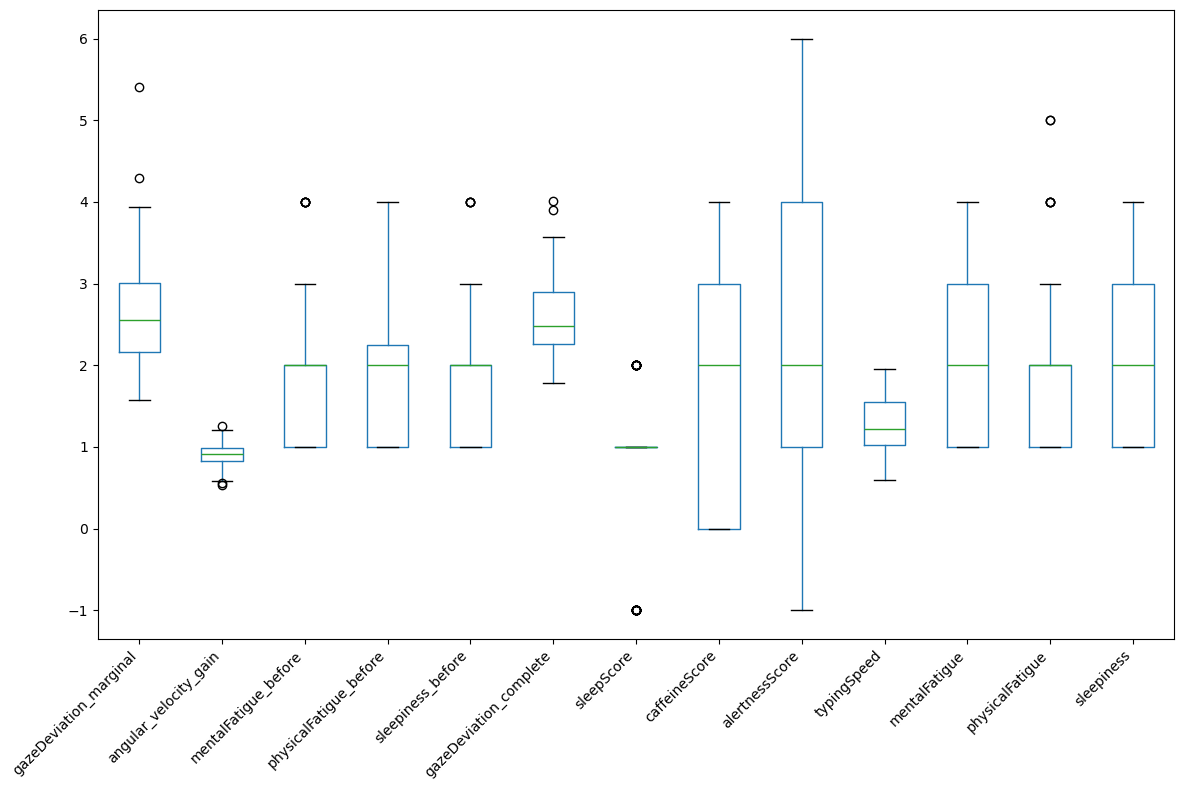

In [18]:
numeric_cols= final_df.select_dtypes(include=['int64', 'float64']).columns

numeric_cols = numeric_cols.drop(['subjectID', 'trialDuration', 'session', 'trial', 'falseSelections', 'correctedErrorRate'])

plt.figure(figsize=(12,8))
final_df[numeric_cols].boxplot()
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()

### Let's see what happens with PCA
### First we will do this with the raw data (no scaling)
objective: further exploration- will show us if there's any trends in the data that we can't see with our own eyes that will help point us down another route


In [19]:
numeric_cols= final_df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12,8))
numeric_df = final_df[numeric_cols]

x = numeric_df.drop(columns=['mentalFatigue'])
y = numeric_df['mentalFatigue']

pca = PCA(n_components=3)
model = pca.fit_transform(x)

# show explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by component: {explained_variance}')
print(f'Total explained variance: {explained_variance.sum()}')

Explained variance by component: [0.99514942 0.00219669 0.00149494]
Total explained variance: 0.9988410432983234


<Figure size 1200x800 with 0 Axes>

From this we can see there are essentially no discernable clusters- MAYBE a slight grouping for mentalFatigue = 4 but we also have so few data points that it's hard to tell

### Now, we will perform PCA again but the data will be scaled first

<Figure size 1200x800 with 0 Axes>

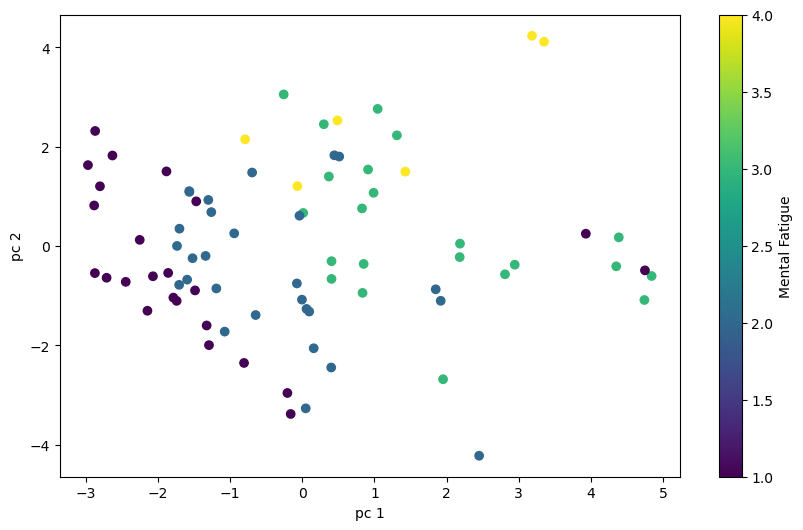

Explained variance by component: [0.22408176 0.15016123]
Total explained variance: 0.3742429903603506


In [20]:
numeric_cols= final_df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12,8))
numeric_df = final_df[numeric_cols]

x = numeric_df.drop(columns=['mentalFatigue'])
y = numeric_df['mentalFatigue']

scaler = StandardScaler()
x = scaler.fit_transform(x) # centers data using z-score method

pca = PCA(n_components=2)
model = pca.fit_transform(x)

# make df with principal components and mental fatigue outcome var
pca_df = pd.DataFrame(data=model, columns=['pc 1', 'pc 2'])
pca_df = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

# plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['pc 1'], pca_df['pc 2'], c=pca_df['mentalFatigue'], cmap='viridis')
plt.xlabel('pc 1')
plt.ylabel('pc 2')
plt.colorbar(scatter, label='Mental Fatigue')
plt.show()

# show explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by component: {explained_variance}')
print(f'Total explained variance: {explained_variance.sum()}')

We can see here that we would need to include many more principal components to capture more of the variance of the data. However, because our scope is exploration for now, we will keep this as is.

### Let's look at a pairplot to see if there are any linear correlations between features
objective: this is simply helping us gain a deeper, visual understanding of the data

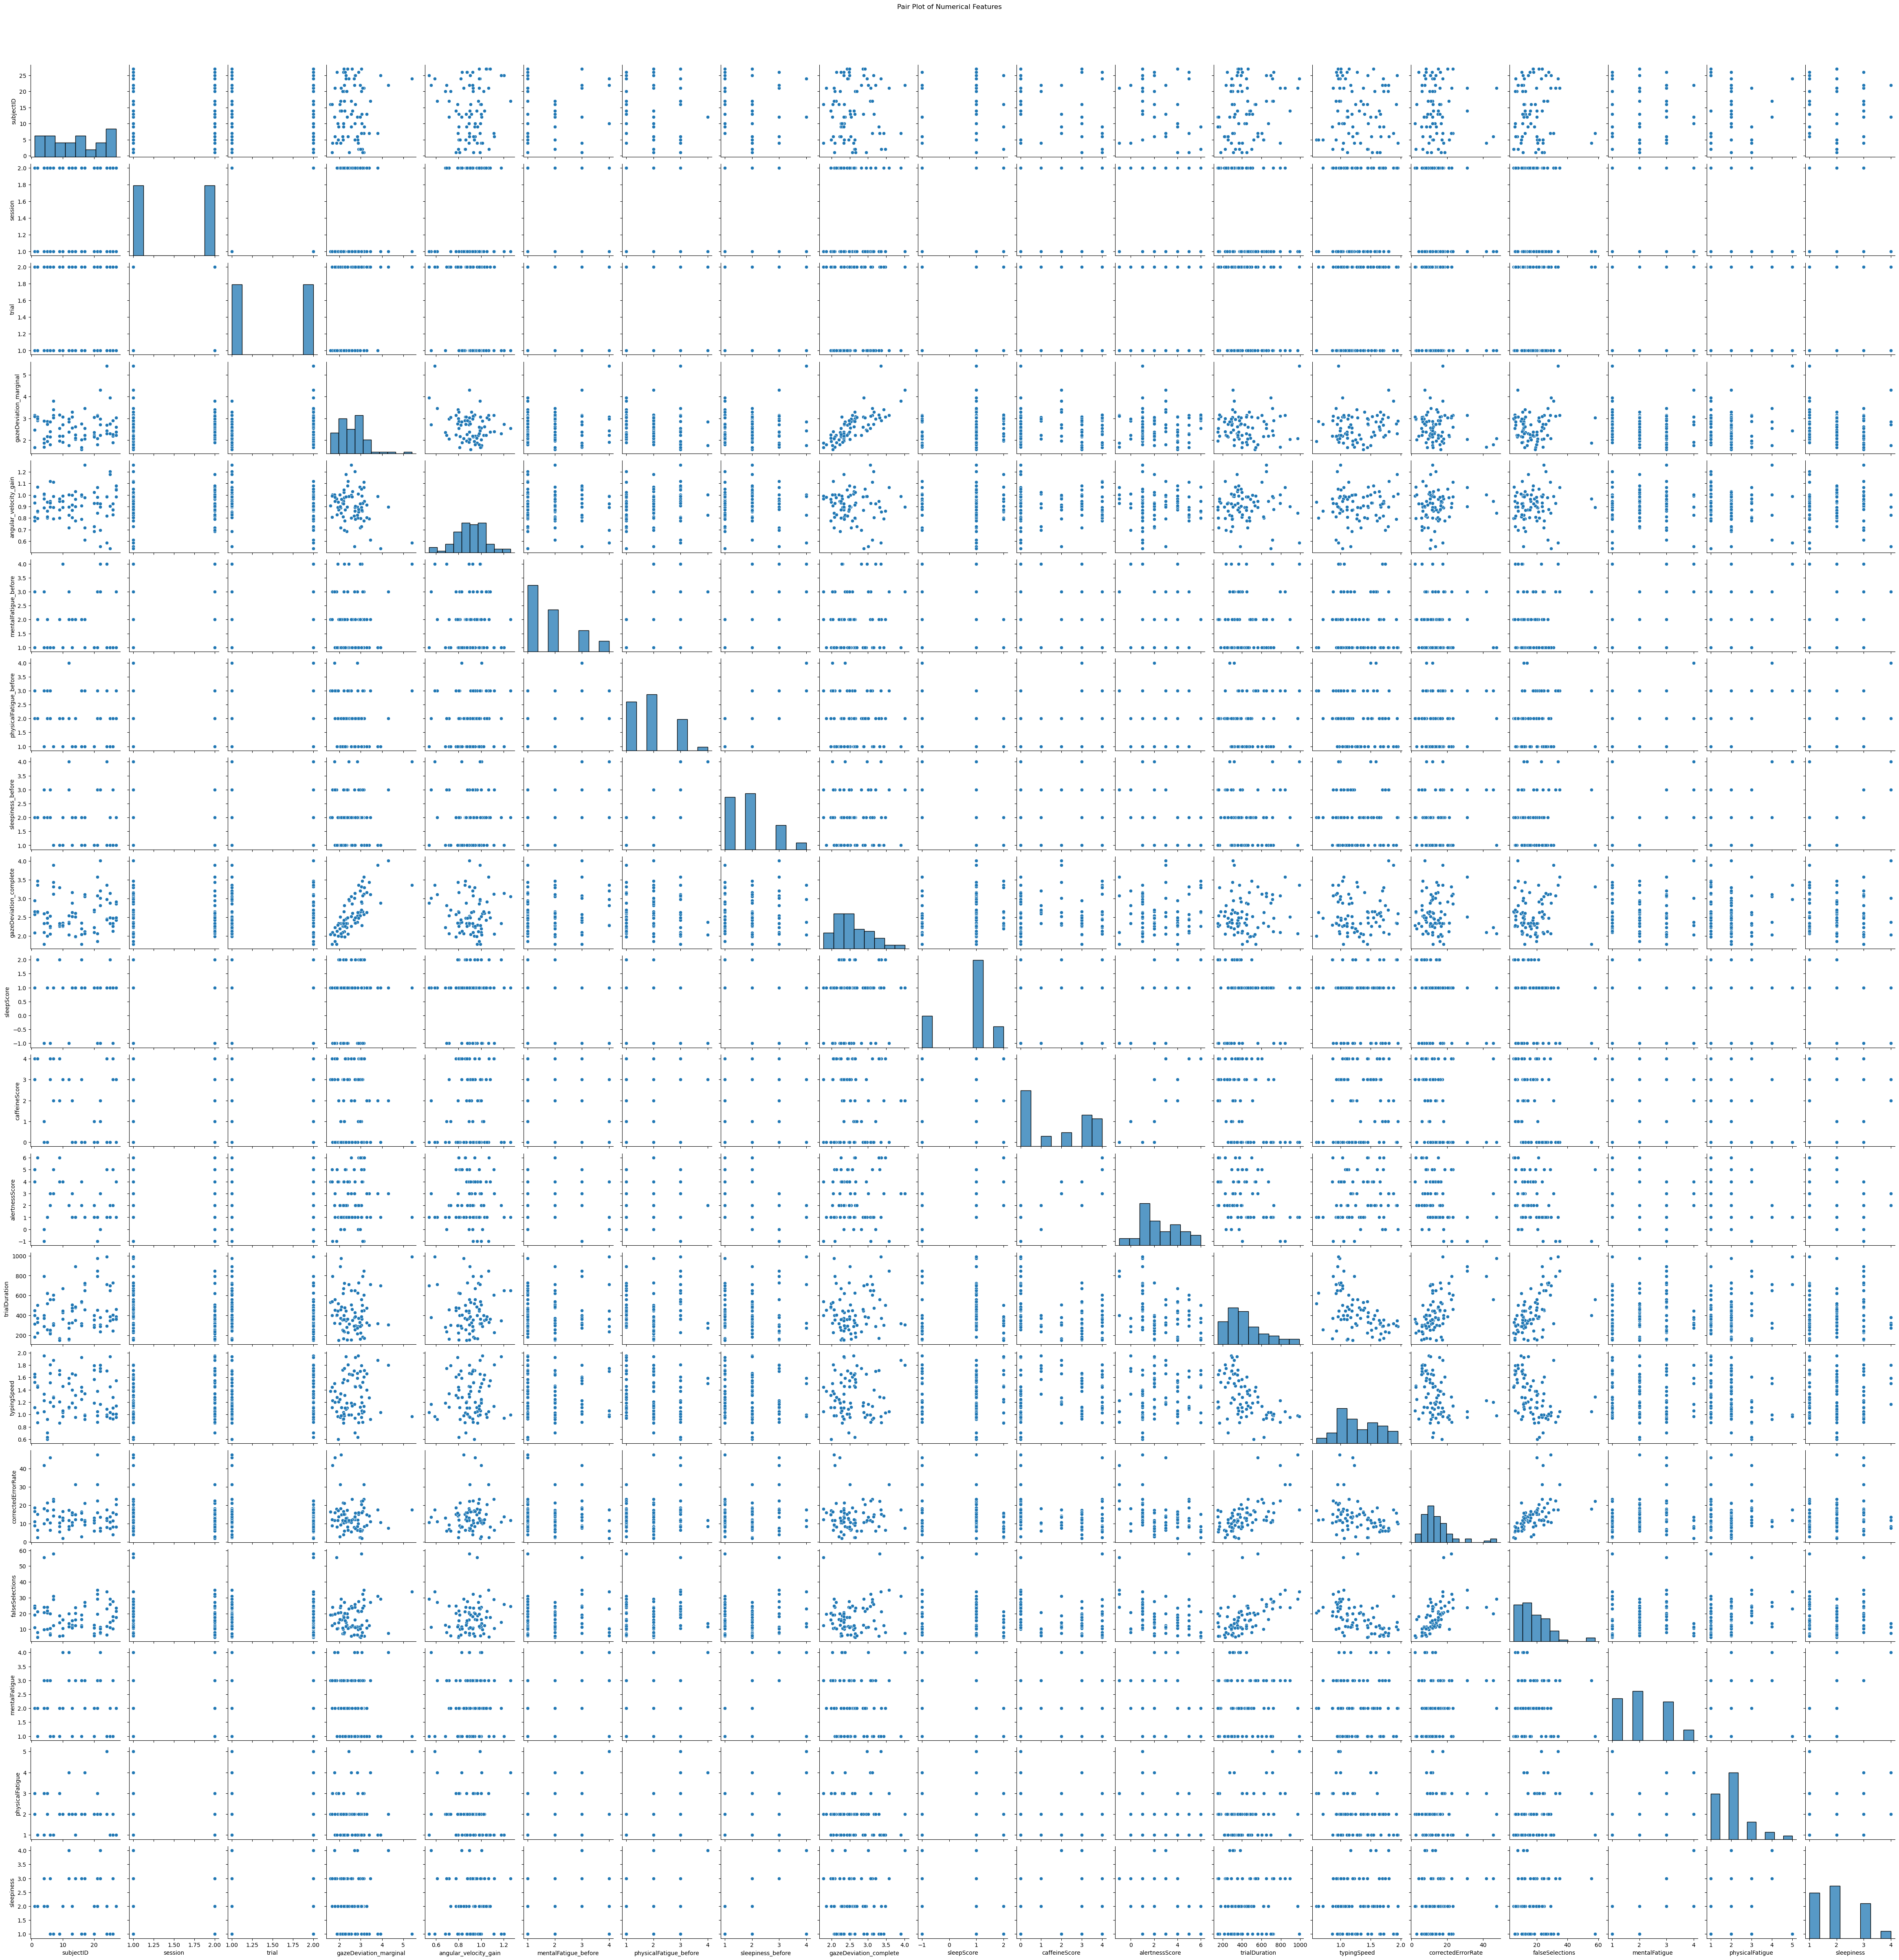

In [21]:
sns.pairplot(numeric_df)
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

It is hard to see on the output, but when we blow up this pairplot we basically see what one would expect. Alertness score seems to be correlated with caffeine score (this makes sense because alertness score is a linear combination of caffeine score and sleep score). It also looks like gaze deviation complete vs gaze deviation marginal has some correlation, which makes sense because they are essentially the same thing just a different number of data points included in the average metrics.

Then, interestingly we're seeing some correlation between trial duration and corrected error rate which is just an interesting observation. 

It doesn't look like there's any correlation between the gaze deviation and angular velocity gain- just an observation- not necessarily important.

---

## Simple model exploration 
## (1) Logistic Regression
First, we need to label the mentalFatigue column to a binary output
We'll say  1 and 2 are 0 (not fatigued) and 3 and 4 are 1 (fatigued) for now as a starting point

A future direction would be to explore labeling only 4's as 1's (fatigued), however we only have 6 data points that are 4's, so this might not be feasible

In [22]:
mental_fatigue_map = {1 : 0, 2: 0, 
                      3 : 1, 4 : 1}

# apply encoding rules using helper function
encoded_df = codify_feature(encoded_df, 'mentalFatigue', mental_fatigue_map)
encoded_df

subjectID  sessionType  session  sessionTime  trial  \
0           1            0        0            0      0   
1           1            0        0            0      1   
2           1            0        1            1      0   
3           1            0        1            1      1   
4           2            0        0            0      0   
..        ...          ...      ...          ...    ...   
75         26            1        1            0      1   
76         27            0        0            0      0   
77         27            0        0            0      1   
78         27            0        1            1      0   
79         27            0        1            1      1   

    gazeDeviation_marginal  angular_velocity_gain  mentalFatigue_before  \
0                 1.654252               0.809592                     3   
1                 3.136516               0.775999                     3   
2                 2.463788               0.988573                     1   
3                 3.090098               0.931487                     1   
4                 2.898291               0.854306                     2   
..                     ...                    ...                   ...   
75                2.265498               0.872967                     1   
76                2.593296               0.983046                     1   
77                3.036665               1.050465                     1   
78                2.215605               1.043273                     3   
79                2.374723               1.080850                     3   

    physicalFatigue_before  sleepiness_before  ...  sleepScore  caffeineScore  \
0                        3                  2  ...           1              4   
1                        3                  2  ...           1              4   
2                        2                  2  ...           1              3   
3                        2                  2  ...           1              3   
4                        2                  2  ...           2              4   
..                     ...                ...  ...         ...            ...   
75                       1                  1  ...           1              4   
76                       2                  1  ...           1              0   
77                       2                  1  ...           1              0   
78                       3                  2  ...           1              3   
79                       3                  2  ...           1              3   

    alertnessScore  trialDuration  typingSpeed  correctedErrorRate  \
0                5     399.293313     1.111965            8.823529   
1                5     448.210546     1.606388           18.627451   
2                4     311.774936     1.655040           11.111111   
3                4     181.115151     1.523892           16.666667   
4                6     373.052926     0.868509           15.000000   
..             ...            ...          ...                 ...   
75               5     358.017037     1.106093           11.475410   
76               1     462.873015     1.140702           23.188406   
77               1     389.072175     0.956121           20.289855   
78               4     357.023045     1.008338           15.068493   
79               4     364.419201     1.547668            8.219178   

    falseSelections  mentalFatigue  physicalFatigue  sleepiness  
0         19.178082              0                3           2  
1         24.752475              0                3           2  
2         11.111111              0                2           2  
3         23.529412              0                2           2  
4         21.153846              0                1           2  
..              ...            ...              ...         ...  
75        15.517241              0                1           1  
76        23.456790              0                1 

### Now, we will build the multinomial logistic regression model

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.86      0.75      0.80         8

    accuracy                           0.85        20
   macro avg       0.85      0.83      0.84        20
weighted avg       0.85      0.85      0.85        20

Confusion Matrix:
[[11  1]
 [ 2  6]]


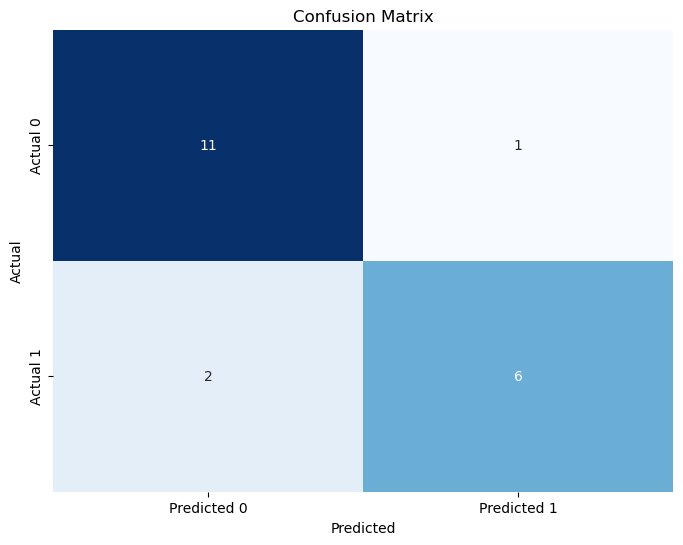

In [23]:
X = encoded_df[['sessionType', 
                'sessionTime', 
                'gazeDeviation_marginal', 
                'angular_velocity_gain', 
                'mentalFatigue_before', 
                'physicalFatigue_before', 
                'sleepiness_before', 
                'trialDifficultyLevel', 
                'gazeDeviation_complete', 
                'sleepScore', 
                'caffeineScore', 
                'alertnessScore', 
                'trialDuration', 
                'typingSpeed', 
                'correctedErrorRate', 
                'falseSelections']]

y = encoded_df['mentalFatigue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)

#scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='lbfgs', max_iter=3000)
model.fit(X_train_scaled, y_train)

# predict on the test set
y_pred = model.predict(X_test_scaled)

# evaluations
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# # SHapley Additive exPlanations - package for this
# explainer = shap.LinearExplainer(model, X_train_scaled, feature_perturbation="interventional")
# shap_values = explainer.shap_values(X_test_scaled)
# shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

This is already performing pretty well for being a simple method! 

Let's see how we can improve :)

### Implement k-fold cross validation

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # scale just predictors

model = LogisticRegression(solver='lbfgs', max_iter=3000)

# define k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=30)

# perform cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")
print(f"Standard deviation of CV accuracy: {cv_scores.std()}")

Cross-validation scores: [0.875  1.     0.75   0.875  0.8125]
Mean CV accuracy: 0.8625
Standard deviation of CV accuracy: 0.08291561975888499


## (1.1) Logistic Regression with Oversampling

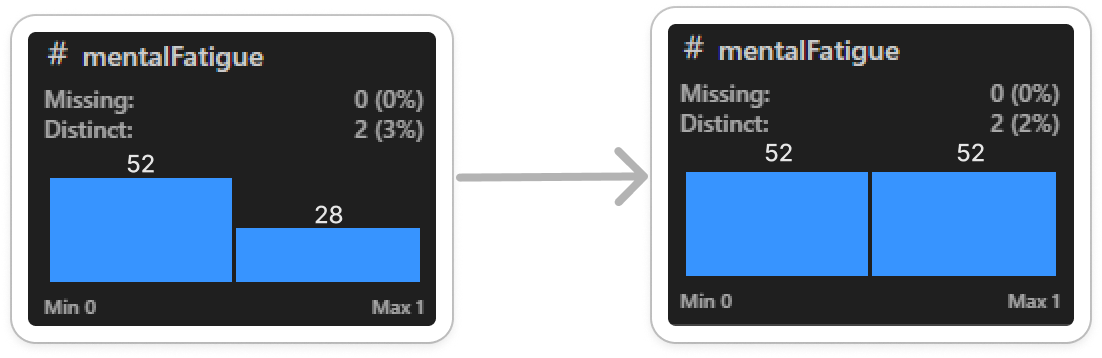

### Let's balance our dataset now by performing some oversampling of the minority class-- 1's in our case
We will do this by using a Synthetic Minority Over-sampling Technique (SMOTE). This technique generates synthetic samples (of the minority class) by interpolating between existing minority-class samples. This helps to mitigate some of the overfitting problems that occur if one were to simply randomly oversample from the existing minority class.

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.78      0.88      0.82         8

    accuracy                           0.85        20
   macro avg       0.84      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20

Confusion Matrix:
[[10  2]
 [ 1  7]]


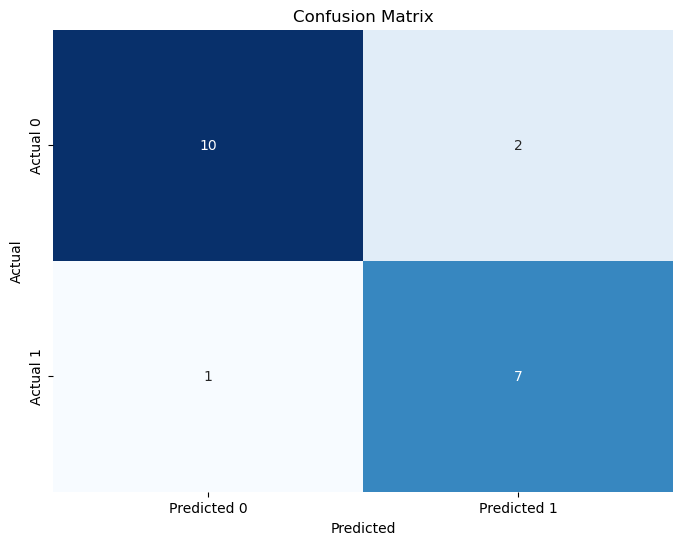

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)

# apply SMOTE to the training data
smote = SMOTE(random_state=15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# train the model hehehe
model = LogisticRegression(solver='lbfgs', max_iter=3000)
model.fit(X_train_scaled, y_train_resampled)

# predict on the test set
y_pred = model.predict(X_test_scaled)

# evaluations
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# # SHapley Additive exPlanations - package for this
# explainer = shap.LinearExplainer(model, X_train_scaled, feature_perturbation="interventional")
# shap_values = explainer.shap_values(X_test_scaled)
# shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)


### Double checking that the oversampling worked properly

In [26]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

Class distribution before SMOTE:
mentalFatigue
0    40
1    20
Name: count, dtype: int64


In [27]:
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

Class distribution after SMOTE:
mentalFatigue
1    40
0    40
Name: count, dtype: int64


### k-fold cross validation on the oversampled dataset

In [28]:
# balance the whole dataset now - SMOTE
smote = SMOTE(random_state=15)
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled) # scale just predictors

model = LogisticRegression(solver='lbfgs', max_iter=3000)

# define k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=30)

# perform cross-validation
cv_scores = cross_val_score(model, X_scaled, y_resampled, cv=kf, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")
print(f"Standard deviation of CV accuracy: {cv_scores.std()}")

Cross-validation scores: [0.9047619  0.9047619  0.80952381 0.85714286 0.85      ]
Mean CV accuracy: 0.8652380952380951
Standard deviation of CV accuracy: 0.03612776521598221


The k-fold results are almost exactly the same (+/- 0.003) as the original dataset without oversampling! This means, if oversampling introduces too much bias into the dataset (to be determined at a later stage), then it may be okay to keep the imbalanced dataset; however, this could have adverse effects in other, more complex, models.

---

# (2) Multiple Model Comparison
Before diving deep into more models individually, let's take a look at how some common ones generally perform in comparison to one another.

Objective: figure out which model architecture will best fit our data

The models we will be comparing are:
- Logistic Regression
- Decision Tree
- K-Nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Random Forest
- Gradient Boosting
- XGBoost
- Neural Network

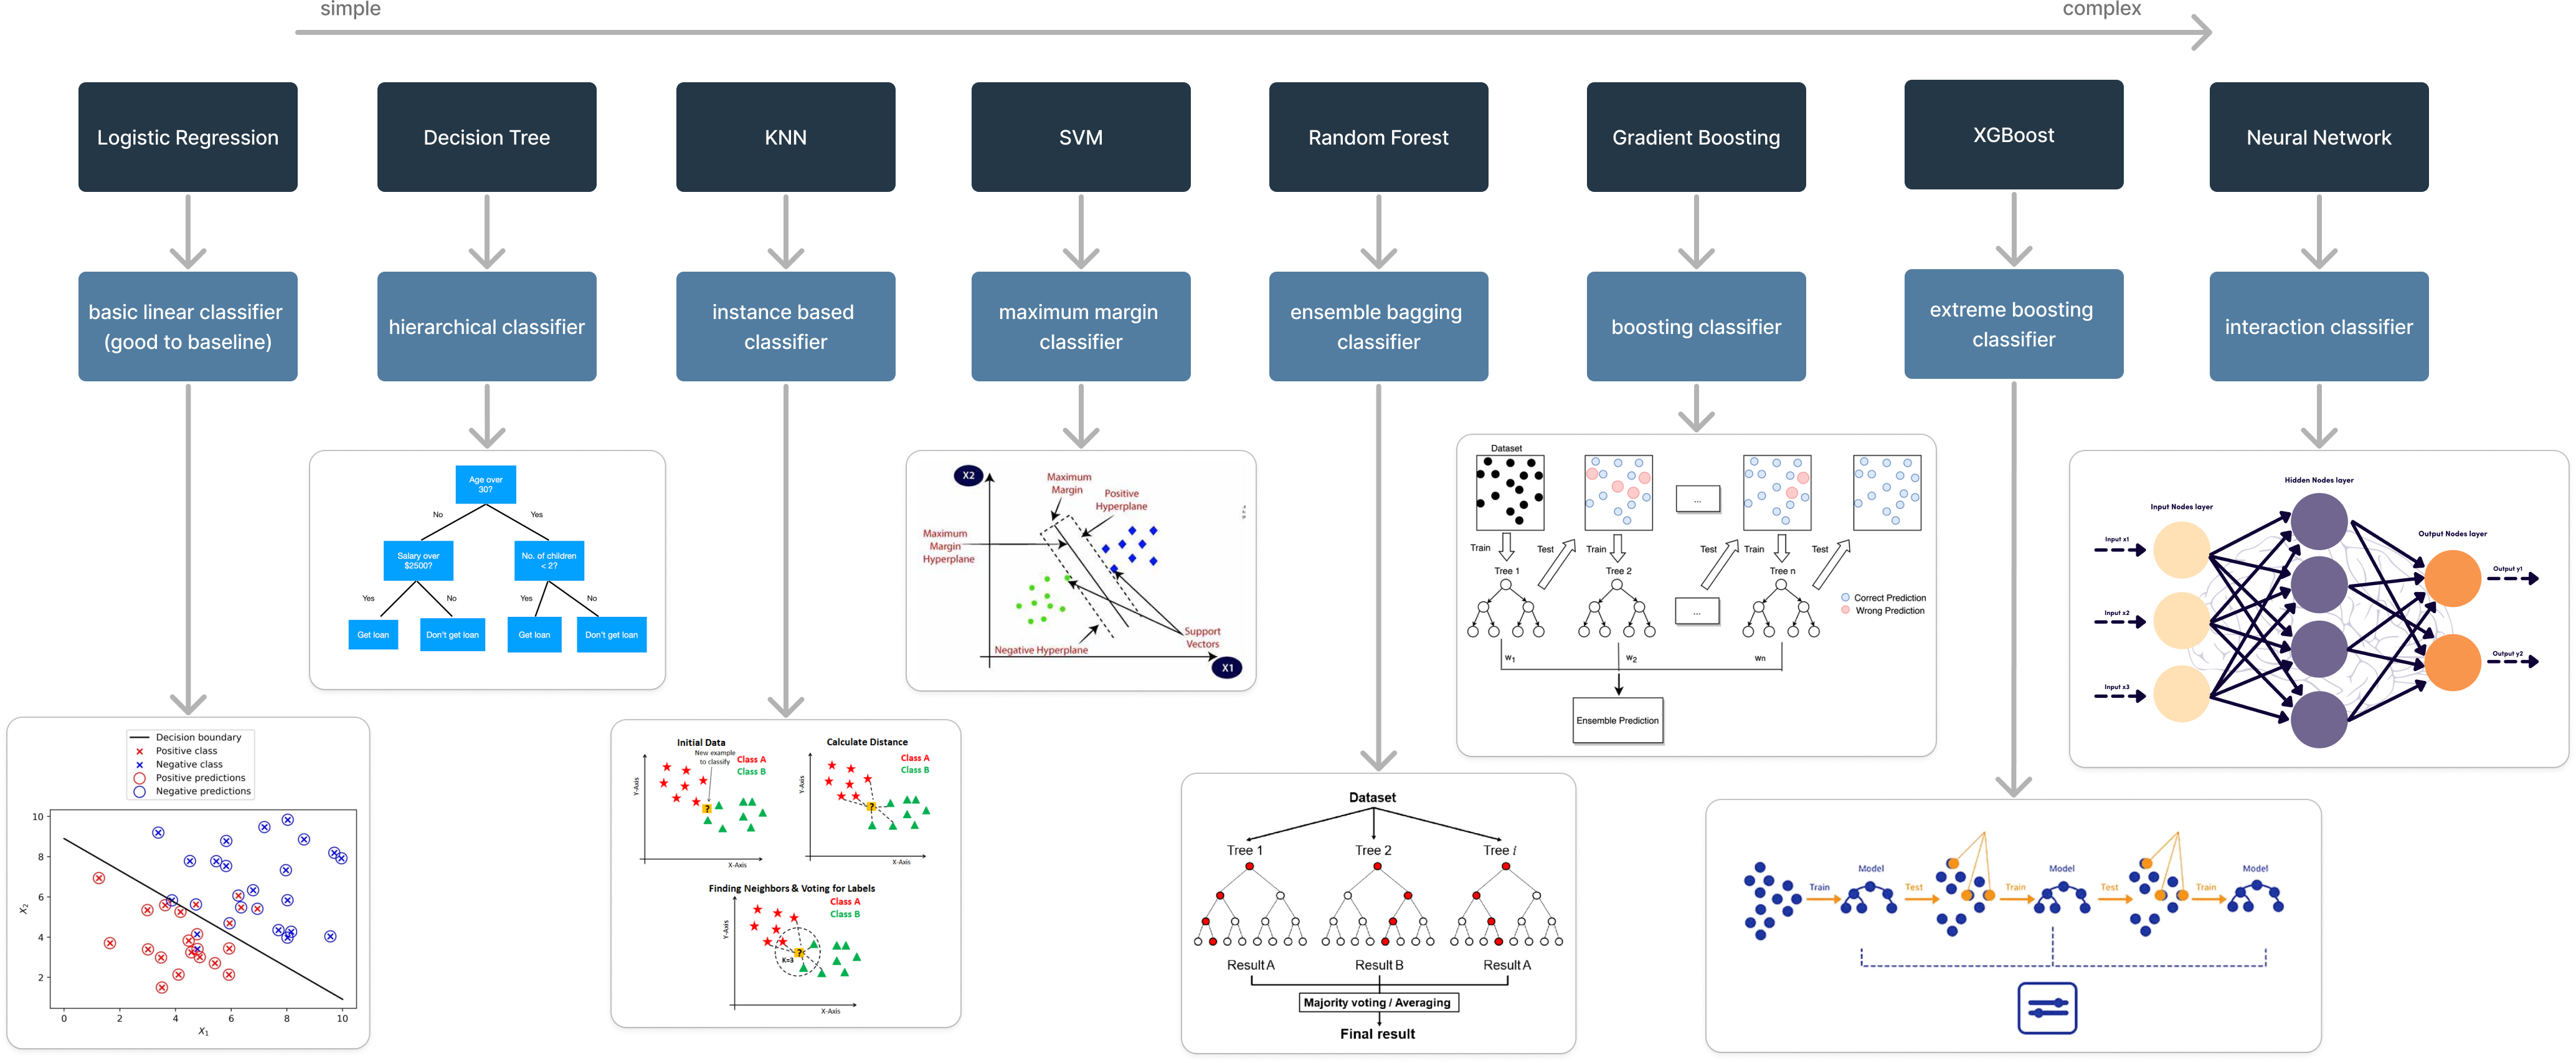

These models were chosen because they are each well known for classification tasks and they gradually increase in complexity.

I have chosen to keep the default metrics for every model e.g. I'm not filling in any parameters for this comparison except for random state for reproducibility and consistency and max_iter for Logistic Regression and Neural Network, only because those don't converge with the default 200 iterations.

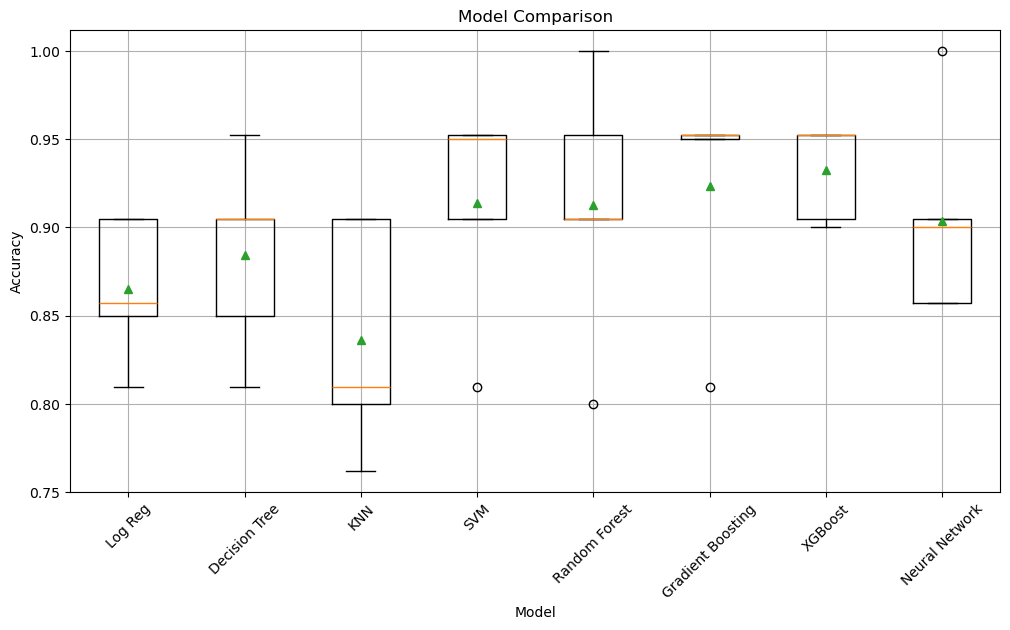

In [29]:
# recall X and y are resampled, and X is scaled, above. We're building this notebook like one continuous script, so no need to redefine them here.

# list of models to evaluate
models = [
    ('Log Reg', LogisticRegression(random_state=30, max_iter = 3000)),
    ('Decision Tree', DecisionTreeClassifier(random_state=30)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(random_state=30)),
    ('Random Forest', RandomForestClassifier(random_state=30)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=30)),
    ('XGBoost', XGBClassifier(random_state=30)),
    ('Neural Network', MLPClassifier(random_state=30, max_iter=350)) # shallow NN uses gradient descent
]

# doing cross validation
dfs = []
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

for name, model in models:
    kf = KFold(n_splits=5, shuffle=True, random_state=30)
    cv_scores = cross_val_score(model, X_scaled, y_resampled, cv=kf, scoring='accuracy')
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print(name)
    # print(classification_report(y_test, y_pred))
    results.append(cv_scores)
    names.append(name)
    # print(classification_report(y_test, y_pred))
    this_df = pd.DataFrame(cv_scores)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(12, 6))
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid()
plt.show()


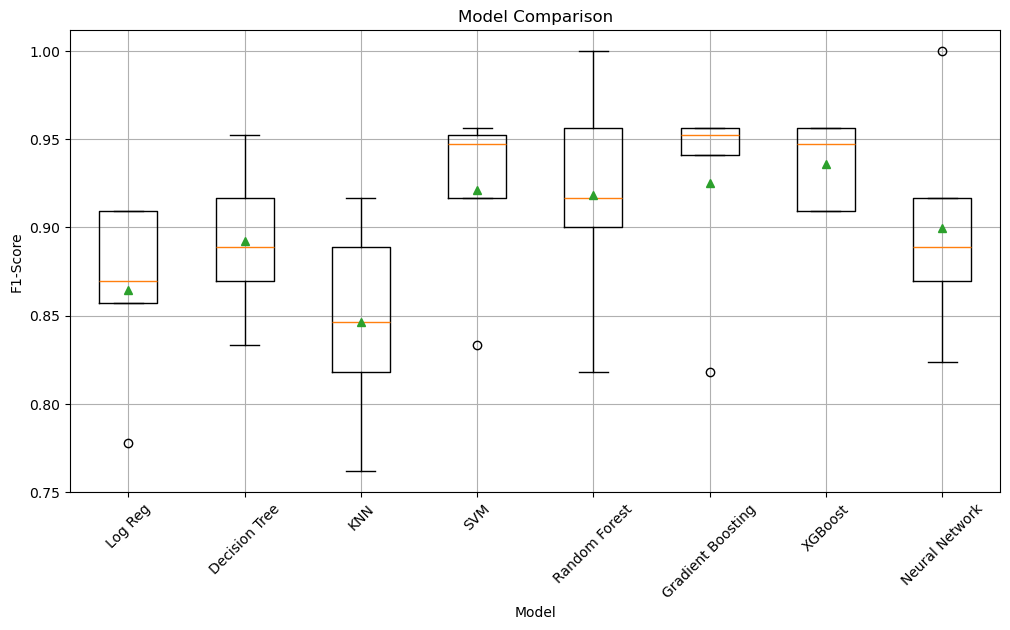

In [30]:
# doing cross validation
dfs = []
results = []
names = []
for name, model in models:
    kf = KFold(n_splits=5, shuffle=True, random_state=30)
    cv_scores = cross_val_score(model, X_scaled, y_resampled, cv=kf, scoring='f1')
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print(name)
    # print(classification_report(y_test, y_pred))
    results.append(cv_scores)
    names.append(name)
    # print(classification_report(y_test, y_pred))
    this_df = pd.DataFrame(cv_scores)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(12, 6))
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Evaluate with more metrics
The above plot is good for a general idea, but we should test by more than just the accuracy metric - let's add more metrics

In [24]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    """
    Lightweight function to test many models and find winners

    Parameters:
    X_train (pd.DataFrame): Training split (scaled)
    y_train (pd.DataFrame): Training target vector
    X_test (pd.DataFrame): Test split (scaled)
    y_test (pd.DataFrame): Test target vector

    Returns:
    pd.DataFrame: DataFrame of predictions
    """
    
    dfs = []
    models = [
        ('Log Reg', LogisticRegression(random_state=30, max_iter = 3000)),
        ('Decision Tree', DecisionTreeClassifier(random_state=30)),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC(random_state=30)),
        ('Random Forest', RandomForestClassifier(random_state=30)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=30)),
        ('XGBoost', XGBClassifier(random_state=30)),
        ('Neural Network', MLPClassifier(random_state=30, max_iter=350)) # shallow NN uses gradient descent
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['not cognitively fatigued', 'cognitively fatigued']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

In [25]:
final = run_exps(X_train_scaled, y_train_resampled, X_test_scaled, y_test)

Log Reg
                          precision    recall  f1-score   support

not cognitively fatigued       0.91      0.83      0.87        12
    cognitively fatigued       0.78      0.88      0.82         8

                accuracy                           0.85        20
               macro avg       0.84      0.85      0.85        20
            weighted avg       0.86      0.85      0.85        20

Confusion Matrix:
[[10  2]
 [ 1  7]]
Decision Tree
                          precision    recall  f1-score   support

not cognitively fatigued       0.67      0.83      0.74        12
    cognitively fatigued       0.60      0.38      0.46         8

                accuracy                           0.65        20
               macro avg       0.63      0.60      0.60        20
            weighted avg       0.64      0.65      0.63        20

Confusion Matrix:
[[10  2]
 [ 5  3]]
KNN
                          precision    recall  f1-score   support

not cognitively fatigued       0.67

### Performance and time metrics
Now, we will randomly sample (bootstrap) our final results dataframe (to get n greater than just 5 and get better estimates of the distribution of metrics from each model) and plot the performance metrics and time metrics

In [26]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

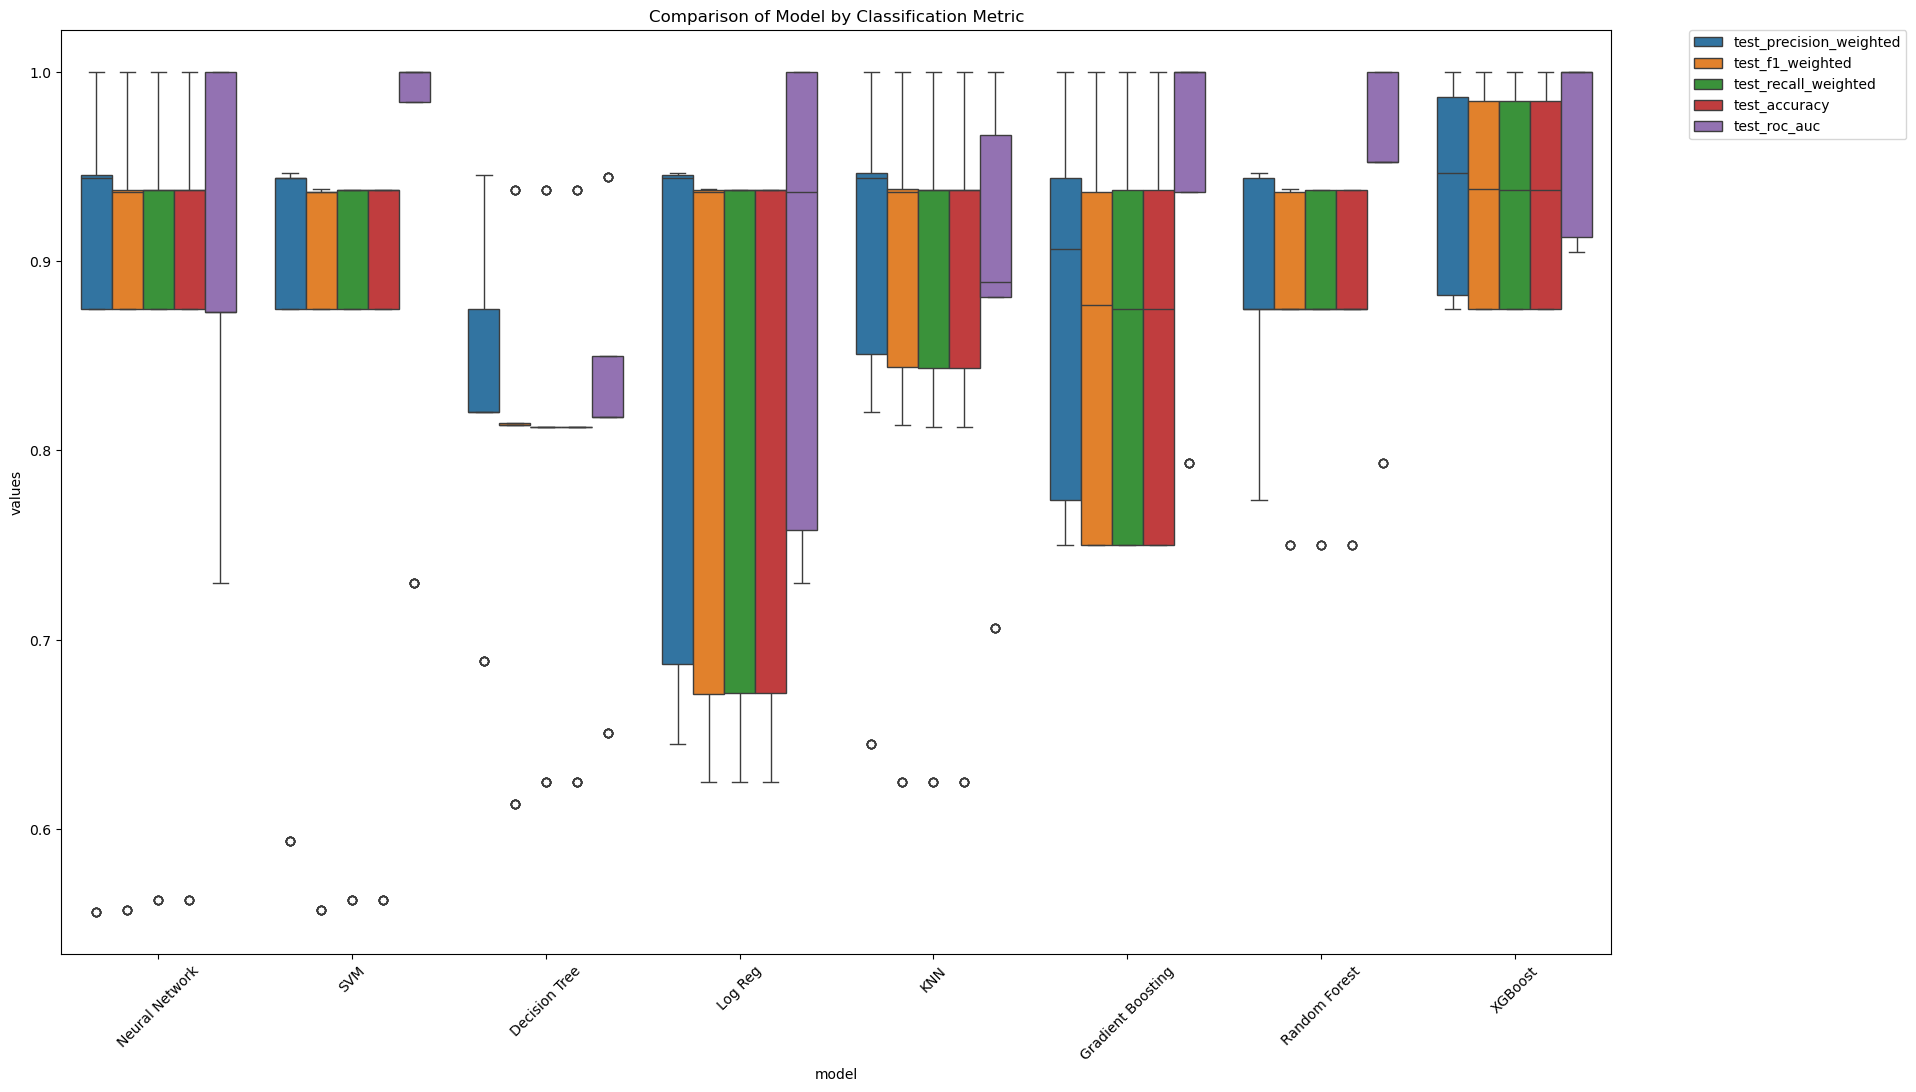

In [27]:
plt.figure(figsize=(20, 12))
# sns.set_theme(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.title('Comparison of Model by Classification Metric')

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

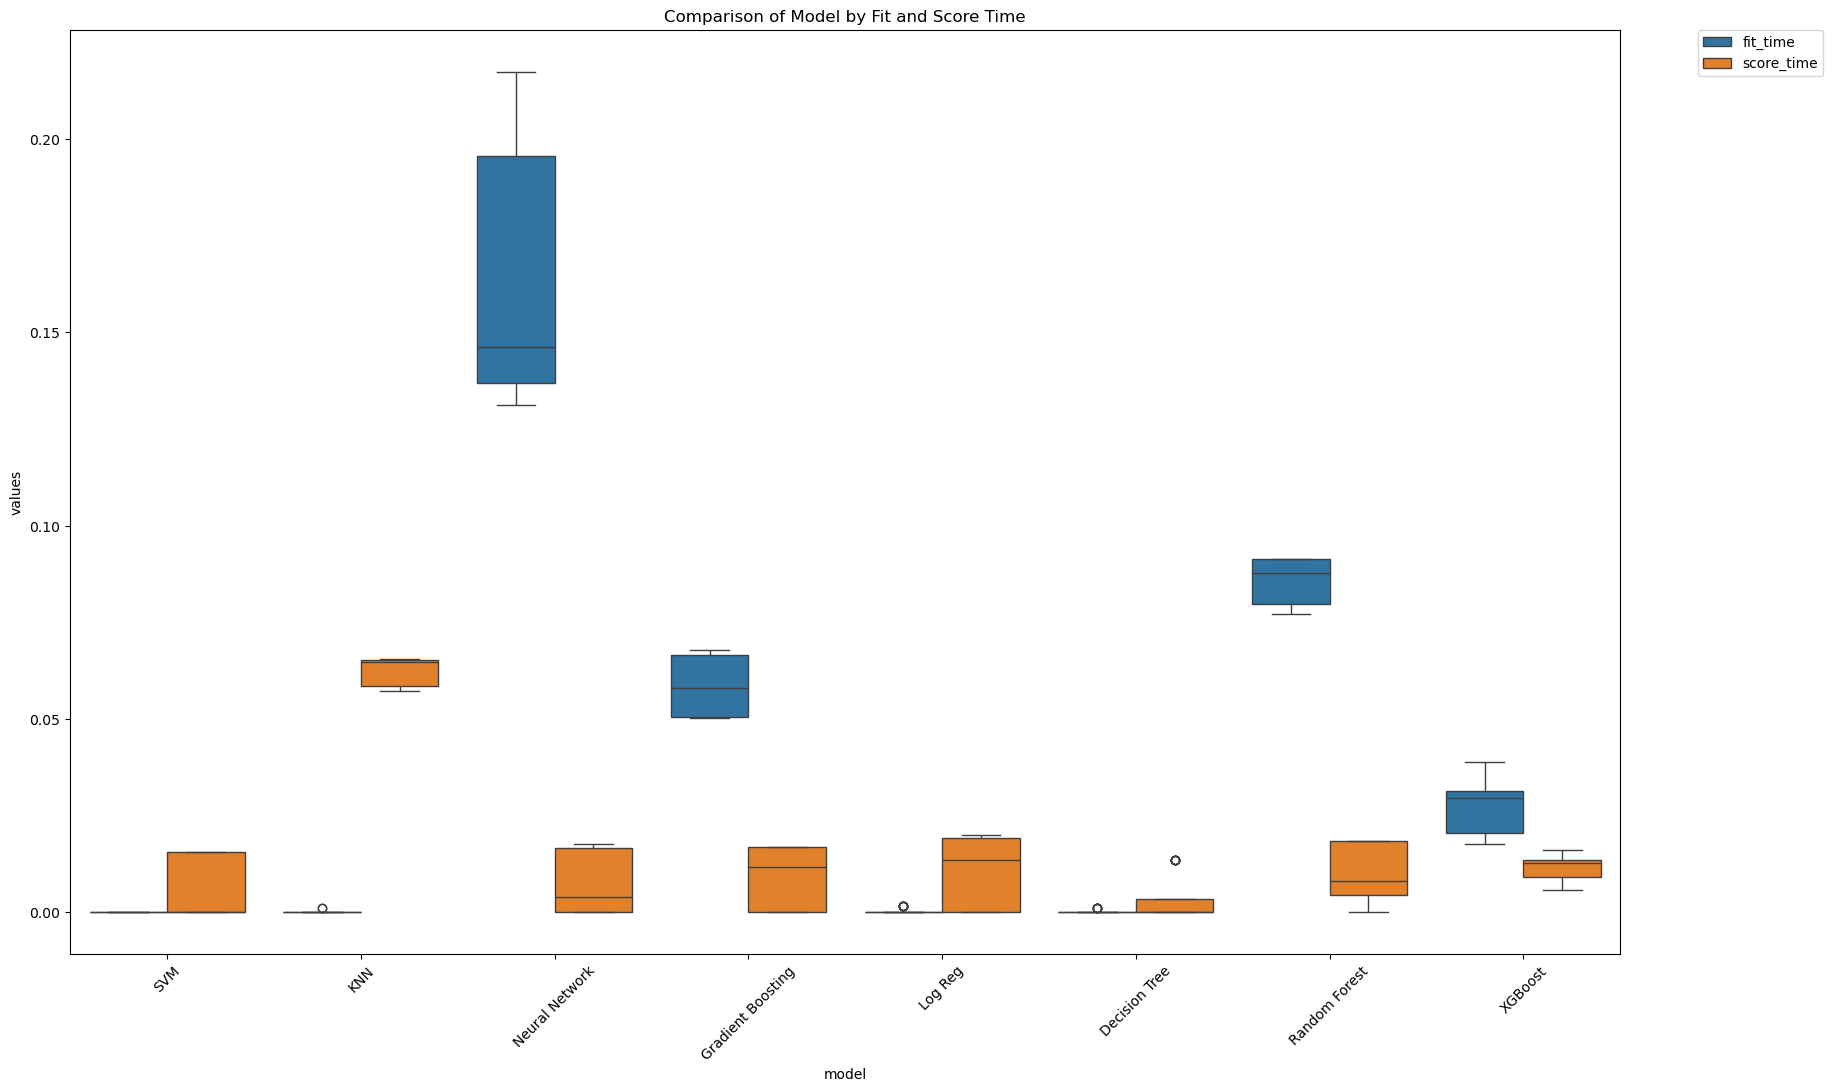

In [28]:
plt.figure(figsize=(20, 12))
# sns.set_theme(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.title('Comparison of Model by Fit and Score Time')

## Model scoring
Now, we will take the mean performance metrics for each model and "score" them

model_score = average of all scoring metrics

In [29]:
metrics = list(set(results_long_nofit.metrics.values))
df = bootstrap_df.groupby(['model'])[metrics].agg(['mean'])

weights = {
    'test_accuracy': 0.2,
    'test_precision_weighted': 0.2,
    'test_recall_weighted': 0.2,
    'test_f1_weighted': 0.2,
    'test_roc_auc': 0.2
}

# calculate composite score
df['composite_score'] = sum(df[metric] * weight for metric, weight in weights.items())

# rank models based on score
df = df.sort_values(by='composite_score', ascending=False)
df

test_accuracy test_roc_auc test_precision_weighted  \
                           mean         mean                    mean   
model                                                                  
XGBoost                0.925000     0.961905                0.932937   
Random Forest          0.883333     0.948148                0.890843   
Gradient Boosting      0.875000     0.950265                0.887679   
KNN                    0.879167     0.893228                0.887703   
Neural Network         0.856250     0.886772                0.858021   
SVM                    0.837500     0.933862                0.848780   
Log Reg                0.841667     0.897354                0.852010   
Decision Tree          0.793750     0.810476                0.825526   

                  test_f1_weighted test_recall_weighted composite_score  
                              mean                 mean                  
model                                                                    
XGBoost                   0.925202             0.925000        0.934009  
Random Forest             0.883333             0.883333        0.897798  
Gradient Boosting         0.875194             0.875000        0.892628  
KNN                       0.879216             0.879167        0.883696  
Neural Network            0.855059             0.856250        0.862470  
SVM                       0.836122             0.837500        0.858753  
Log Reg                   0.841480             0.841667        0.854835  
Decision Tree             0.791732             0.793750        0.803047

### Model scoring with computation time penalty
penalty_model_score = average of all scoring metrics - average of time metrics

In [103]:
metrics = list(set(results_long_nofit.metrics.values))
df = bootstrap_df.groupby(['model'])[metrics].agg(['mean'])

time_metrics = list(set(results_long_fit.metrics.values))
time_df = bootstrap_df.groupby(['model'])[time_metrics].agg(['mean'])

weights = {
    'test_accuracy': 0.2,
    'test_precision_weighted': 0.2,
    'test_recall_weighted': 0.2,
    'test_f1_weighted': 0.2,
    'test_roc_auc': 0.2
}

time_weights = {
    'score_time': 0.5,
    'fit_time': 0.5
}

# calculate composite score
df['composite_score'] = sum(df[metric] * weight for metric, weight in weights.items()) - sum(time_df[time_metric] * time_weight for time_metric, time_weight in time_weights.items())

# rank models based on score
df = df.sort_values(by='composite_score', ascending=False)
df

test_accuracy test_roc_auc test_precision_weighted  \
                           mean         mean                    mean   
model                                                                  
XGBoost                0.925000     0.961905                0.932937   
Gradient Boosting      0.875000     0.950265                0.887679   
SVM                    0.837500     0.933862                0.848780   
KNN                    0.879167     0.893228                0.887703   
Random Forest          0.883333     0.948148                0.890843   
Log Reg                0.841667     0.897354                0.852010   
Decision Tree          0.793750     0.810476                0.825526   
Neural Network         0.856250     0.886772                0.858021   

                  test_f1_weighted test_recall_weighted composite_score  
                              mean                 mean                  
model                                                                    
XGBoost                   0.925202             0.925000        0.914698  
Gradient Boosting         0.875194             0.875000        0.859115  
SVM                       0.836122             0.837500        0.856409  
KNN                       0.879216             0.879167        0.852279  
Random Forest             0.883333             0.883333        0.850623  
Log Reg                   0.841480             0.841667        0.850021  
Decision Tree             0.791732             0.793750        0.801068  
Neural Network            0.855059             0.856250        0.776320

We have tested a slew of techniques; however, these comparisons are NOT exhaustive. This only considered mean precision and recall which is purely a performance metric for comparison across _general_ models. We should still test the methods further.

---

# Extreme Gradient Boost (XGBoost)
### In-depth model optimization
We will continue with the XGBoost Machine Learning algorithm for the cognitive fatigue predictions. A preliminary approach is below; for robust model evaluations please see `02-cmm-model-dev.ipynb` for the validation process.

('Random Forest', RandomForestClassifier(random_state=30)),
('Gradient Boosting', GradientBoostingClassifier(random_state=30)),
('XGBoost', XGBClassifier(random_state=30)),

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.83      0.91         6

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16

Confusion Matrix:
[[10  0]
 [ 1  5]]


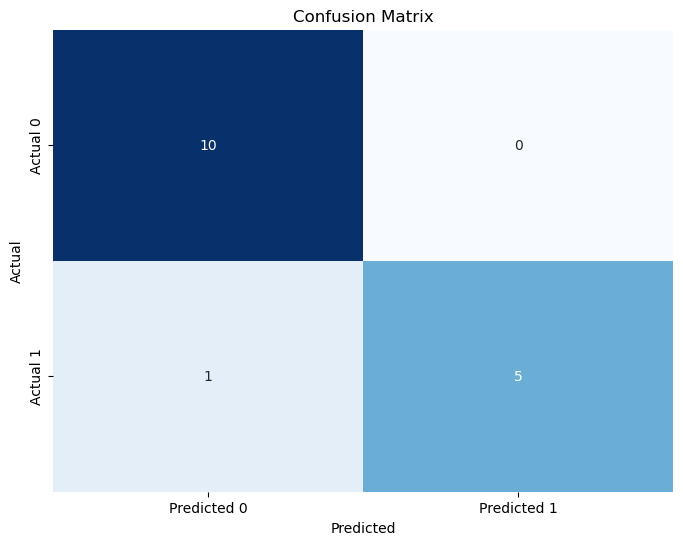

In [170]:
# redefine vars for clarity
X = encoded_df[[
                # 'sessionType', 
                # 'sessionTime', 
                'gazeDeviation_marginal', 
                'angular_velocity_gain', 
                'mentalFatigue_before', 
                'physicalFatigue_before', 
                'sleepiness_before', 
                'trialDifficultyLevel', 
                'gazeDeviation_complete', 
                # 'sleepScore', 
                # 'caffeineScore', 
                'alertnessScore', 
                'trialDuration', 
                'typingSpeed',
                'correctedErrorRate',
                'falseSelections'
                ]]

y = encoded_df['mentalFatigue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# apply SMOTE to the training data
smote = SMOTE(random_state=30)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# train the model hehehe
model = XGBClassifier(random_state=30)

model.fit(X_train_scaled, y_train_resampled)

# predict on the test set
y_pred = model.predict(X_test_scaled)

# evaluations
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In the code snippet above, I trained and assessed the model once with sleep score, caffeine score, and alertness score included, then again with only alertness score included. Recall that alertness score is the sum of sleep score and caffeine score. We get a model performance weighted accuracy increase of 10% across RF, GB, and XGB when we only include alertness score. 

When we exclude the input subjective measures of mental fatigue and sleepiness, we get a big model performance decrease of ~20%. However, excluding perceived physical fatigue has no effect.

If we exclude every input subjective measure, our model performance decreases to 50%

In [171]:
# balance the whole dataset now - SMOTE
smote = SMOTE(random_state=30)
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled) # scale just predictors

model = XGBClassifier(
                    # n_estimators = 300,
                    #   subsample = 0.8,
                    #   min_child_weight = 3,
                    #   max_depth = 6,
                    #   learning_rate = 0.01,
                    #   colsample_bytree = 0.5,
                      random_state=30)

# define k-fold cross-validator
kf = RepeatedStratifiedKFold(n_splits=5, random_state=30) #, shuffle=True)
# kf = KFold(n_splits=5, random_state=30, shuffle=True)

# perform cross-validation
cv_scores = cross_val_score(model, X_scaled, y_resampled, cv=kf, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")
print(f"Standard deviation of CV accuracy: {cv_scores.std()}")

cv_scores = cross_val_score(model, X_scaled, y_resampled, cv=kf, scoring='roc_auc')

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV ROC: {cv_scores.mean()}")
print(f"Standard deviation of CV ROC: {cv_scores.std()}")

Cross-validation scores: [0.95238095 0.80952381 0.9047619  0.85714286 0.75       0.85714286
 1.         0.95238095 0.9047619  0.8        0.76190476 0.76190476
 0.85714286 0.85714286 0.8        0.9047619  0.9047619  1.
 0.9047619  0.7        0.9047619  0.9047619  0.9047619  0.71428571
 0.8        0.95238095 0.9047619  0.9047619  0.9047619  1.
 0.80952381 0.9047619  0.95238095 0.85714286 0.85       0.85714286
 1.         0.85714286 0.71428571 0.95       0.80952381 0.95238095
 0.9047619  0.85714286 0.95       0.80952381 0.95238095 0.9047619
 0.95238095 0.9       ]
Mean CV accuracy: 0.8776190476190474
Standard deviation of CV accuracy: 0.07603108327245355

Cross-validation scores: [0.96363636 0.85454545 0.97272727 0.91818182 0.93       0.87272727
 1.         0.98181818 0.93636364 0.94       0.84545455 0.91818182
 1.         0.89090909 0.87       0.94545455 0.90909091 1.
 0.96363636 0.83       0.92727273 0.94545455 1.         0.89090909
 0.82       0.98181818 0.96363636 0.89090909 0.9636363

### Hyperparameter Tuning

In [94]:
# step 1: define the params to test
params = [{
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0, 1, 2, 3, 4, 5],
    'lambda': [0, 1, 2, 3, 4, 5],
    'alpha': [0, 1, 2, 3, 4, 5]
}]

# step 2: test them on our model using grid search cv
clf = GridSearchCV(model, param_grid=params, cv=3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_scaled, y_resampled)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


In [95]:
best_clf.best_params_

{'criterion': 'squared_error',
 'learning_rate': 1.623776739188721,
 'loss': 'exponential',
 'n_estimators': 5000,
 'subsample': 0.05}

In [161]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0, 1, 2, 3, 4, 5],
    'lambda': [0, 1, 2, 3, 4, 5],
    'alpha': [0, 1, 2, 3, 4, 5]
}

# Instantiate the model
xgb_model = xgb.XGBClassifier(random_state=30)

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1, random_state=30)

# Fit the random search model
random_search.fit(X_scaled, y_resampled)

# Best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best ROC AUC Score: {random_search.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 0.5, 'alpha': 0}
Best ROC AUC Score: 0.9250909090909092


### Continue to `02-cmm-model-dev.ipynb` for model development next steps and model validation.